In [2]:
import numpy as np
import skimage
from PIL import Image, ImageFilter
from scipy.ndimage.filters import convolve
from skimage import io
import matplotlib.pyplot as plt

In [3]:
np.random.seed(42)

In [29]:
import argparse
import numpy as np
from skimage import io
from scipy.optimize import minimize


# helper functions
def get_coords(height, width):
    coords = []
    for h in range(height):
        for w in range(width):
            coords.append([h, w])
    return np.array(coords)

def get_normalized_coords(height, width):
    coords = []
    height, width = np.linspace(0, 1, height), np.linspace(0, 1, width)
    for h in height:
        for w in width:
            coords.append([h, w])
    return np.array(coords)

def normalize(image):
    return 0.5 * (2 * (image-np.min(image))/(np.max(image)-np.min(image)) - 1)


def get_parameters(res, K):
    """ Gets the estimated parameters from results

    :param res:
    :param K: the number of images used
    """
    params = res.x
    shifts = np.array(params[:2*K]).reshape(-1, 2)
    angles = np.array(params[2*K:2*K+K])
    gamma = params[-1]
    return shifts, angles, gamma


# Building Blocks
def cov(x_i, x_j, r=1.0, a=0.04):
    """ 
    The covariance function that determines smoothness of GP
    """
    x_i_sum = np.sum(x_i ** 2, axis=1).reshape(-1, 1)
    x_j_sum = np.sum(x_j ** 2, axis=1)
    dist = x_i_sum + x_j_sum - (2 * np.dot(x_i, x_j.T))
    out = a * np.exp(-(dist / r ** 2))
    return out


def transform_mat(x_i, x_j, center, shift, angle, gamma=2):
    """ This is the transformation matrix that converts a high
    resolution image into a low resolution image
    In the paper this is denoted using W_ji
    """
    x_i_sum = np.sum(x_i ** 2, axis=1).reshape(-1, 1)
    u_j = psf_center(x_j, center, shift, angle)
    u_j_sum = np.sum(u_j ** 2, axis=1)
    dist = x_i_sum + u_j_sum - (2 * np.dot(x_i, u_j.T))
    out = np.exp(-(dist / gamma ** 2))
    out /= np.sum(out, axis=0)
    return out.T


def psf_center(x_j, center, shift, angle):
    """ Used to calculate the center of the psf
    This is the vector u_j in the paper
    """
    angle = np.radians(angle)
    rotation_matrix = [
        [np.cos(angle), np.sin(angle)],
        [-np.sin(angle), np.cos(angle)]]
    rotation_matrix = np.array(rotation_matrix)

    u = np.dot(rotation_matrix, (x_j - center).T)
    u = u.T + center + shift
    return u


def variance(Z_x, W_K, beta):
    Z_x_inv = np.linalg.inv(Z_x)
    a = 0
    for w in W_K:
        a += np.dot(w.T, w)
    sigma = Z_x_inv + (beta * a)
    sigma = np.linalg.inv(sigma)
    return sigma


def mean(W_K, Y_K, sigma, beta):
    a = 0
    for w, y in zip(W_K, Y_K):
        y = y.reshape(-1, 1)
        a += np.dot(w.T, y)
    mu = beta * np.dot(sigma, a)
    return mu


def marginal_log_likelihood(Z_x, W_K, Y_K, beta, M, K):
    sigma = variance(Z_x, W_K, beta)
    mu = mean(W_K, Y_K, sigma, beta)

    likelihood = 0
    for w, y in zip(W_K, Y_K):
        y = y.reshape(-1, 1)
        y_sum = np.sum(y ** 2, axis=0)
        w_u = np.dot(w, mu)
        w_u_sum = np.sum(w_u ** 2, axis=0)
        likelihood += y_sum + w_u_sum - (2 * np.dot(y.flatten(), w_u.flatten()))
    likelihood = likelihood[0]
    likelihood *= beta
    likelihood += np.dot(np.dot(mu.T, np.linalg.inv(Z_x)), mu)[0][0]
    Z_x_sign, Z_x_logdet = np.linalg.slogdet(Z_x)
    sigma_sign, sigma_logdet = np.linalg.slogdet(sigma)
    likelihood += (Z_x_sign * Z_x_logdet) - (sigma_sign * sigma_logdet) - (K * M * np.log(beta))
    likelihood *= -0.5
    return likelihood


def compute_likelihood(X_n, X_m, Y_K, center, shifts, angles, beta, gamma):
    Z_x = cov(X_n, X_n)  + beta * np.eye(len(X_n))

    W_K = [transform_mat(X_n, X_m, center, shift, angle, gamma) for shift, angle in zip(shifts, angles)]
    W_K = np.array(W_K)

    K = len(shifts)
    M = len(X_m)
    return -marginal_log_likelihood(Z_x, W_K, Y_K, beta=beta, M=M, K=K)


def compute_likelihood_theta(theta, X_n, X_m, Y_K, center, beta, shifts, angles, gamma=4):
    K = len(Y_K)
    M = len(X_m)
    var = 1 / beta

    Z_x = cov(X_n, X_n) + (var * np.eye(len(X_n)))
    if shifts is None:
        shifts = np.array(theta[:K]).reshape(-1, 1)
        shifts = np.concatenate((shifts, shifts), axis=1)
        
    if angles is None:
        angles = np.array(theta[2*K:2*K+K])

    if gamma is None:
        gamma = theta[-1]

    W_K = [transform_mat(X_n, X_m, center, shift, angle, gamma) for shift, angle in zip(shifts, angles)]
    W_K = np.array(W_K)
    nll = -marginal_log_likelihood(Z_x, W_K, Y_K, beta=beta, M=M, K=K)
    return nll

(1000, 667)


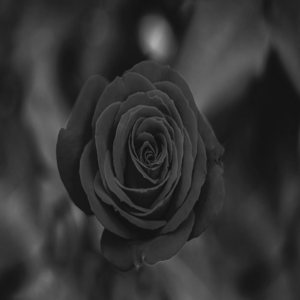

In [35]:
image = Image.open('../images/rose.jpg').convert('L')
image = image.resize((300, 300), resample=Image.BICUBIC)
image

In [38]:
hr_image = Image.open('../images/rose.jpg').convert('L')
hr_image = hr_image.resize((200, 200), resample=Image.BICUBIC)

num_images = 16

gamma = 2
noise = 0.05
beta = 1 / (0.05 ** 2)
var = 1 / beta

center = np.array([5, 5])
shifts = [[0, 0]]  # store for comparison
angles = [0]  # store for comparison
Y_K = []

# generate LR images
w, h = hr_bimage.size
w_down, h_down = w//4, h//4

image = np.asarray(hr_image).flatten().reshape(-1, 1)
w, h = hr_image.size
w_down, h_down = w//4, h//4
center = np.array([h_down//2, w_down//2])
center_h, center_w = center

X_n = get_coords(h, w)
X_m = get_coords(h_down, w_down)

trans_mat = transform_mat(X_n, X_m, center, [0, 0], 0, gamma=gamma)
Y_k = np.dot(trans_mat, image).reshape(h_down, w_down)
Y_k = Y_k[center_h-4:center_h+5, center_w-4:center_w+5].flatten()
Y_k += var * np.random.randn(*Y_k.shape)
Y_K.append(normalize(Y_k))

for _ in range(num_images-1):
    shift = np.random.randint(-2, 3)
    shifts.append([shift, shift])
    angle = np.random.randint(-4, 5)
    angles.append(angle)
    trans_mat = transform_mat(X_n, X_m, center, [shift, shift], angle, gamma=gamma)
    Y_k = np.dot(trans_mat, image).reshape(h_down, w_down)
    Y_k = Y_k[center_h-4:center_h+5, center_w-4:center_w+5].flatten()
    Y_k += var * np.random.randn(*Y_k.shape)
    Y_K.append(normalize(Y_k))

X_m = get_coords(9, 9)
X_n = get_coords(50, 50)
center = np.array([5,5])
#theta = [0 for _ in range(16)]
print('Estimating Parameters')
res = minimize(compute_likelihood_theta, theta,
               args=(X_n, X_m, Y_K, center, beta, None, angles, None),
               method='CG',
               options={'disp': True, 'maxiter': 1})

print(res.status)
params = res.x
params

Estimating Parameters
         Current function value: -1697.679953
         Iterations: 1
         Function evaluations: 76
         Gradient evaluations: 4
1


array([ 3.97575549e-01, -6.08274481e-01,  4.06713885e-01,  1.63566466e-03,
       -2.30403459e-02,  1.98348468e-01, -5.75524644e-01, -6.24274414e-01,
        2.07368491e-01,  1.26584510e-01,  4.37806734e-01, -6.68236235e-01,
        3.76975765e-01, -4.49428542e-01,  4.78945119e-01,  3.88297719e-01,
        3.68381215e+00])

In [43]:
np.concatenate(([3],[4]))

array([3, 4])

In [18]:
#estimated_shifts = params

In [37]:
theta = estimated_shifts
theta = list(theta)
theta.append(4)
theta

[0.34161166894589706,
 -0.42178364398585755,
 0.6105861831626302,
 0.5427392575543695,
 0.2759320824797115,
 0.13021745456707995,
 0.5398866190506307,
 0.5869332134176528,
 -1.1364625619523274,
 -1.042050519202261,
 -0.5400805359608699,
 0.2001910733227994,
 0.203433045207983,
 -1.1379988227003155,
 0.6100962213479111,
 0.2749751258103381,
 4]

In [ ]:
hr_image = Image.open('../images/rose.jpg').convert('L')
hr_image = hr_image.resize((200, 200), resample=Image.BICUBIC)

num_images = 16

gamma = 2
noise = 0.05
beta = 0.05 ** 2

center = np.array([5, 5])
shifts = [[0, 0]]  # store for comparison
angles = [0]  # store for comparison
Y_K = []

# generate LR images
w, h = hr_image.size
w_down, h_down = w//4, h//4

image = np.asarray(hr_image).flatten().reshape(-1, 1)
w, h = hr_image.size
w_down, h_down = w//4, h//4
center = np.array([h_down//2, w_down//2])
center_h, center_w = center

X_n = get_coords(h, w)
X_m = get_coords(h_down, w_down)

trans_mat = transform_mat(X_n, X_m, center, [0, 0], 0, gamma=gamma)
Y_k = np.dot(trans_mat, image).reshape(h_down, w_down)
Y_k = Y_k[center_h-4:center_h+5, center_w-4:center_w+5].flatten()
Y_k += noise * np.random.randn(*Y_k.shape)
Y_K.append(normalize(Y_k))

for _ in range(num_images-1):
    shift = np.random.randint(-2, 3)
    shifts.append([shift, shift])
    angle = np.random.randint(-4, 5)
    angles.append(angle)
    trans_mat = transform_mat(X_n, X_m, center, [shift, shift], angle, gamma=gamma)
    Y_k = np.dot(trans_mat, image).reshape(h_down, w_down)
    Y_k = Y_k[center_h-4:center_h+5, center_w-4:center_w+5].flatten()
    Y_k += noise * np.random.randn(*Y_k.shape)
    Y_K.append(normalize(Y_k))
Y_K = np.array(Y_K)

X_m = get_coords(9, 9)
X_n = get_coords(50, 50)

Z_x = cov(X_n, X_n) + beta * np.eye(len(X_n))

W_K = [transform_mat(X_n, X_m, center, shift, angle, gamma) for shift, angle in zip(shifts, angles)]
W_K = np.array(W_K)

nll = -marginal_log_likelihood(Z_x, W_K, Y_K, beta=beta, M=81, K=16)
nll

In [ ]:
image = Image.open('../images/rose.jpg').convert('L')

num_images = 16

gamma = 2
beta = 0.05 ** 2

center = np.array([5, 5])
shifts = [[0, 0]]  # store for comparison
angles = [0]  # store for comparison
Y_K = []

w, h = image.size
w_down, h_down = w//4, h//4

# apply gaussian blur
#img = image.filter(ImageFilter.GaussianBlur(2))
X_m = get_coords(9, 9)
X_n = get_coords(50, 50)
psf = transform_mat(X_n, X_m, center, [0, 0], 0, gamma)
img = np.asarray(image)
img = convolve(img, psf, origin=0)
# downsample image
img = Image.fromarray(img)
img = img.resize((w_down, h_down), resample=Image.BICUBIC)
# get 9x9 image centered on the center
w, h = img.size
center_w, center_h = w//2, h//2
img = np.asarray(img)
img = img[center_h-4:center_h+5, center_w-4:center_w+5]
img = img.flatten()
assert len(img) == 81
Y_K.append(normalize(img))

for _ in range(num_images-1):
    # translate image
    shift = np.random.randint(-2, 3)
    shifts.append([shift, shift])
    img = image.transform(image.size, Image.AFFINE, (1, 0, shift, 0, 1, shift))
    # rotate image
    angle = np.random.randint(-4, 5)
    angles.append(angle)
    img = img.rotate(angle, resample=Image.BICUBIC)
    # apply gaussian blur
    img = img.filter(ImageFilter.GaussianBlur(2))
    # downsample image
    img = img.resize((w_down, h_down), resample=Image.BICUBIC)
    # get 9x9 image centered on the center
    w, h = img.size
    center_w, center_h = w//2, h//2
    img = np.asarray(img)
    img = img[center_h-4:center_h+5, center_w-4:center_w+5]
    img = img.flatten()
    assert len(img) == 81
    Y_K.append(normalize(img))
Y_K = np.array(Y_K)

X_m = get_coords(9, 9)
X_n = get_coords(50, 50)

Z_x = cov(X_n, X_n) + beta * np.eye(len(X_n))

W_K = [transform_mat(X_n, X_m, center, shift, angle, gamma) for shift, angle in zip(shifts, angles)]
W_K = np.array(W_K)

nll = -marginal_log_likelihood(Z_x, W_K, Y_K, beta=beta, M=81, K=16)
nll

In [ ]:
num_images = 16
#theta = np.zeros((num_images*3+1,))
#theta[-1] = 4  # gamma

X_m = get_coords(9, 9)
X_n = get_coords(50, 50)

# set initial image and params
beta = 0.05 ** 2
center = np.array([5, 5])
shifts = [[0, 0]]  # store for comparison
angles = [0]  # store for comparison
gamma = 4
Y_K = []

w, h = image.size
w_down, h_down = w//4, h//4

print('Generating Initial Low Image')
# apply gaussian blur
psf = transform_mat(X_n, X_m, center, [0, 0], 0, gamma)
img = np.asarray(image)
img = convolve(img, psf, origin=0)
img = Image.fromarray(img)
# downsample image
img = img.resize((w_down, h_down), resample=Image.BICUBIC)
# get 9x9 image centered on the center
w, h = img.size
center_w, center_h = w//2, h//2
img = np.asarray(img)
img = img[center_h-4:center_h+5, center_w-4:center_w+5]
img = img.flatten()
assert len(img) == 81
Y_K.append(normalize(img))


for idx in range(num_images-1):
    print('Generating low image %d/%d' % (idx, num_images-1))
    # translate image
    shift = np.random.randint(-2, 3)
    shifts.append([shift, shift])
    img = image.transform(image.size, Image.AFFINE, (1, 0, shift, 0, 1, shift))
    # rotate image
    angle = np.random.randint(-4, 5)
    angles.append(angle)
    img = img.rotate(angle, resample=Image.BICUBIC)
    # apply gaussian blur
    psf = transform_mat(X_n, X_m, center, [0, 0], 0, gamma)
    img = np.asarray(image)
    img = convolve(img, psf, origin=0)
    img = Image.fromarray(img)
    # downsample image
    img = img.resize((w_down, h_down), resample=Image.BICUBIC)
    # get 9x9 image centered on the center
    w, h = img.size
    center_w, center_h = w//2, h//2
    img = np.asarray(img)
    img = img[center_h-4:center_h+5, center_w-4:center_w+5]
    img = img.flatten()
    assert len(img) == 81
    Y_K.append(normalize(img))
Y_K = np.array(Y_K)

print(shifts)
print(angles)
print(gamma)

theta = [4]
print('Estimating Parameters')
res = minimize(compute_likelihood_theta, theta,
               args=(X_n, X_m, Y_K, center, beta, shifts, angles),
               method='CG',
               options={'disp': True})

print(res.status)
params = res.x
params

#angles = np.array(params[2*16:2*16+16])
#gamma = params[-1]
# print(shifts)
# print(angles)
# print(gamma)